# EE5213/CS623 Assignment 2 - Part A - NN

Before we start, please put your name and LUMS ID(8 digit) in the following cell.

In [ ]:
rollnumber = 21100171
name = "Muhammad Sameer"

### Instructions (IMPORTANT)

When completing the notebook, please adhere to the following rules:
- Do not write or modify any code outside of code blocks. (You can make copy of the notebook if you want to play with the code, but for the notebook you submit the code should remain un-modified).

```python
########### WRITE YOUR CODE BELOW ######

print("Hello World")

########### END OF CODE ###############
```

- Do not add or delete any cells from the notebook. You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run (for the output that has been shown in this notebook).

# MALE/FEMALE Image Classification

First thing first. Assignment seems difficult, but it is not. Purpose of this assignment is to give you the idea of different architectures of neural network and how to optimize the parameters. This also acts as foundation for you to understand the buzz word Deep Learning.

In part A of the assignment we will configure the number of layers and nodes in a Neural Network (play with neural network structure). To train and test these neural networks we will use a subset of male and female face images from following kaggle dataset:

https://www.kaggle.com/cashutosh/gender-classification-dataset

# Environment Setup


Importing packages

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.io import imread_collection
from sklearn.model_selection import train_test_split

Run this cell if you are using Google Colab to run this notebook, otherwise comment this out. It is recommended that you use Colab because models can take some time durring learning, because of large dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# replace this your google drive path of the zip file of dataset provided with this homework
!unzip -o -q "/content/drive/MyDrive/CS623/Data.zip" -d "/content"

dataset_dir = "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If you are running this in the <b>local enviroment</b>, then paste the folder path where you unzipped your dataset. 

In [ ]:
# dataset_dir = "C:/Users/username/folder1/folder2/HW02"

## Utility funcitons

In [ ]:
binary_classes = {0:"Male", 1:"Female"}

Given image matrix this will plot the random sample of images from it. 

In [ ]:
def diplay_sample_images(images, num_rows, num_cols, title_text):
    image_list = []

    for i in range(num_rows*num_cols):
        rand_num = random.randint(0, len(images)-1)
        image_list.append(images[rand_num])

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, image_list):
        ax.imshow(im)
        ax.axis("off")
    
    plt.suptitle(title_text, fontsize=20)
    plt.show()

Function which will help us plotting the training results.

In [ ]:
def graph_it(value, y_axis_label):
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'k')
    plt.xlabel("Epochs")
    plt.ylabel(y_axis_label)
    plt.show()

# Loading the data

Tke kaggle dataset for part A resides in Data/dataset1 folder with over 11000 male/female images. We will now load these images and display some of them. Note that the images in this dataset are tight crops of the faces.

Total instances Female class: 5841
Total instances male class: 5808
Total instances train instances: 11649


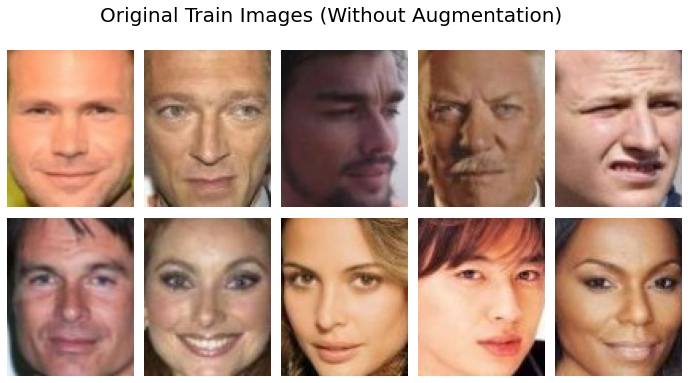

In [ ]:
# reading male images
male_dir = os.path.join(dataset_dir, 'Data/dataset1/male/*.jpg')
male_images = imread_collection(male_dir)

# reading female images
female_dir = os.path.join(dataset_dir, 'Data/dataset1/female/*.jpg')
female_images = imread_collection(female_dir)

# concatinating the both male and female image matrix
images = np.row_stack((np.array(male_images), np.array(female_images)))

print("Total instances Female class:", len(female_images))
print("Total instances male class:", len(male_images))
print("Total instances train instances:", len(images))
# displaying some sample images from dataset
diplay_sample_images(images, 2, 5, "Original Train Images (Without Augmentation)")

# Preprocess the Images

Convert the images into standard form to feed it our models and generate outut labels.

We will also split the into two sets - 80% of the images will be used for training and 20% will act as the test set.

In [ ]:
image_width = 80
image_height = 100
channels = 3

In [ ]:
number_of_data_instances = len(images)

# normalizing
X = images / 255.

# creating y lables for images (0 for Male class, 1 for Female Class)
male_labels = np.zeros((len(male_images), 1), dtype=np.int)
female_labels = np.ones((len(female_images), 1), dtype=np.int)
Y = np.row_stack((male_labels, female_labels))

# shuffle the data instances
permuations = np.random.permutation(number_of_data_instances)
X = np.take(X, permuations, axis=0)
Y = np.take(Y, permuations, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9319, 100, 80, 3)
(9319, 1)
(2330, 100, 80, 3)
(2330, 1)


We will implement the model as a multi-class classification problem with two output nodes (one for male and one for female). To do that we need to convert output lables into categorical features, such that for every label (binary) there are two entries.

In [ ]:
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(y_train.shape)
print(y_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(9319, 1)
(2330, 1)
(9319, 2)
(2330, 2)


For simple neural network models you need your images flattened out. So this code just do that.

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], image_height*image_width*channels)
X_test_flat = X_test.reshape(X_test.shape[0], image_height*image_width*channels)

print(X_train_flat.shape)
print(X_test_flat.shape)

(9319, 24000)
(2330, 24000)


# Model 1 : Single-Layer Neural Network

In this part you will create a simple model with single hidden layer in Keras and train it on the training set and test it on the test set.

### (Graded) Define your model in Keras

- The model should have single hidden layer. 
- You can experiment with the number of neurons and see how well it performs. 
- The output layer will contain two neruons. 
- You must specify the loss funciton to use. 
- Also you need to select the training algorthm (optimizer), learning rate, batch size and number of epochs to use 
- And don't forget to compile your model.
- Submit data for at least <b>5 different architectures</b> to demonstrate how the accuracy changes with number of neurons
- For each of the architectures include number of neurons, optimizer used, learning ate, batch size, number of epochs and accuracy achieved
- The final run that you submit should include the configuration with the highest accuracy you are able to achieve
- Your final solution should achieve at least 90% accuracy on the test set. <b>Higher accuracy will earn higher score on the HW</b>

**Model1**

In [ ]:
model1 = Sequential() #using sequential API
optimizer1 =optimizers.Adam(learning_rate=0.001)
epochs1 = 100
batch_size1 = 10

########### WRITE YOUR CODE BELOW ######
model1.add(layers.Input(shape=(X_train_flat.shape[1],)))
model1.add(layers.Dense(150,activation='relu'))
model1.add(layers.Dense(2,activation='softmax'))
########### END OF CODE ###############

model1.summary()
model1.compile(loss='categorical_crossentropy',optimizer=optimizer1,metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 150)               3600150   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 302       
Total params: 3,600,452
Trainable params: 3,600,452
Non-trainable params: 0
_________________________________________________________________


**Model2**

In [ ]:
model2 = Sequential() #using sequential API
optimizer2 = optimizers.Adam(learning_rate=0.001)
epochs2 = 150
batch_size2 = 20

########### WRITE YOUR CODE BELOW ######
model2.add(layers.Input(shape=(X_train_flat.shape[1],)))
model2.add(layers.Dense(200,activation='relu'))
model2.add(layers.Dense(2,activation='softmax'))
########### END OF CODE ###############

model2.summary()
model2.compile(loss='categorical_crossentropy',optimizer=optimizer2,metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 200)               4800200   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 402       
Total params: 4,800,602
Trainable params: 4,800,602
Non-trainable params: 0
_________________________________________________________________


**Model3**

In [ ]:
model3 = Sequential() #using sequential API
optimizer3 = optimizers.Adam(learning_rate=0.005)
epochs3 = 200
batch_size3 = 100

########### WRITE YOUR CODE BELOW ######
model3.add(layers.Input(shape=(X_train_flat.shape[1],)))
model3.add(layers.Dense(500,activation='relu'))
model3.add(layers.Dense(2,activation='softmax'))
########### END OF CODE ###############

model3.summary()
model3.compile(loss='categorical_crossentropy',optimizer=optimizer3,metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 500)               12000500  
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 1002      
Total params: 12,001,502
Trainable params: 12,001,502
Non-trainable params: 0
_________________________________________________________________


**Model4**

In [ ]:
model4 = Sequential() #using sequential API
optimizer4 = optimizers.SGD(learning_rate=0.01)
epochs4 = 200
batch_size4 = 200

########### WRITE YOUR CODE BELOW ######
model4.add(layers.Input(shape=(X_train_flat.shape[1],)))
model4.add(layers.Dense(800,activation='relu'))
model4.add(layers.Dense(2,activation='softmax'))
########### END OF CODE ###############

model4.summary()
model4.compile(loss='categorical_crossentropy',optimizer=optimizer4,metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 800)               19200800  
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 1602      
Total params: 19,202,402
Trainable params: 19,202,402
Non-trainable params: 0
_________________________________________________________________


**Model5**

In [ ]:
model5 = Sequential() #using sequential API
optimizer5 = optimizers.SGD(learning_rate=0.01)
epochs5 = 200
batch_size5 = 200

########### WRITE YOUR CODE BELOW ######
model5.add(layers.Input(shape=(X_train_flat.shape[1],)))
model5.add(layers.Dense(1500,activation='relu'))
model5.add(layers.Dense(2,activation='softmax'))
########### END OF CODE ###############

model5.summary()
model5.compile(loss='categorical_crossentropy',optimizer=optimizer5,metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1500)              36001500  
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 3002      
Total params: 36,004,502
Trainable params: 36,004,502
Non-trainable params: 0
_________________________________________________________________


### (Graded) Train your model

- Train the model by calling the fit function of the model you define above and pass the relevent trainign data and labels.
- Record the training history in history_model1 returned by fit function. 

In [ ]:
history_model1 = None

########### WRITE YOUR CODE BELOW ######

history_model1= model5.fit(X_train_flat,y_train_cat,epochs=200,batch_size=200)
########### END OF CODE ###############

Epoch 1/200
47/47 [==============================] - 1s 18ms/step - loss: 1.8601 - accuracy: 0.5798
Epoch 2/200
47/47 [==============================] - 1s 17ms/step - loss: 0.6110 - accuracy: 0.6717
Epoch 3/200
47/47 [==============================] - 1s 17ms/step - loss: 0.5813 - accuracy: 0.6920
Epoch 4/200
47/47 [==============================] - 1s 17ms/step - loss: 0.5597 - accuracy: 0.7058
Epoch 5/200
47/47 [==============================] - 1s 17ms/step - loss: 0.5445 - accuracy: 0.7282
Epoch 6/200
47/47 [==============================] - 1s 17ms/step - loss: 0.5256 - accuracy: 0.7334
Epoch 7/200
47/47 [==============================] - 1s 17ms/step - loss: 0.5679 - accuracy: 0.7330
Epoch 8/200
47/47 [==============================] - 1s 17ms/step - loss: 0.5010 - accuracy: 0.7628
Epoch 9/200
47/47 [==============================] - 1s 17ms/step - loss: 0.5196 - accuracy: 0.7423
Epoch 10/200
47/47 [==============================] - 1s 17ms/step - loss: 0.4714 - accuracy: 0.7752

Plotting the training history. 

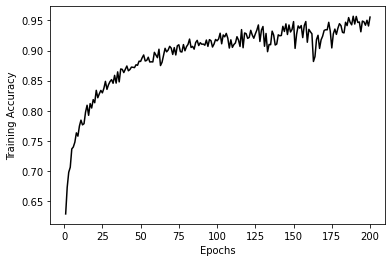

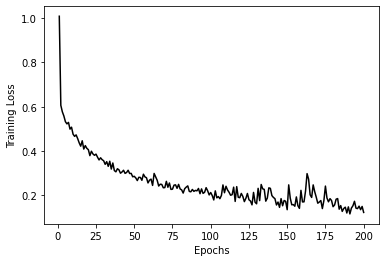

In [ ]:
accuracy1 = history_model1.history['accuracy']
graph_it(accuracy1, "Training Accuracy")

loss1 = history_model1.history['loss']
graph_it(loss1, "Training Loss")

### (Graded) Evaluate your model. 

This can be done by calling the evaluate funciton of your model with the relevent test data and labels. <b>You should be able to acheive test accuracy of at least $\ge$ 90%.

In [ ]:
test_loss1 = 0
test_acc1 = 0

########### WRITE YOUR CODE BELOW ######
test_loss1,test_acc1 = model5.evaluate(X_test_flat,y_test_cat)

########### END OF CODE ###############

print('\nTest accuracy:', test_acc1)
print("Test Loss:", test_loss1)

73/73 [==============================] - 0s 4ms/step - loss: 0.1837 - accuracy: 0.9318

Test accuracy: 0.9317596554756165
Test Loss: 0.18365944921970367


### (Graded) Insert your results in this cell

For each of the 5 architectures you report, include number of neurons, optimizer used, learning rate, batch size, number of epochs and accuracy achieved

########### WRITE YOUR RESULTS BELOW ######
> **Model1**

* *Hidden layer Neurons*:150
* *Optimizer*:Adam
* *batch size*:10
* *learning rate*:0.001
* *epochs*:100
* *Accuracy*:91%

---
> **Model2**

* *Hidden layer Neurons*:200
* *Optimizer*:Adam
* *batch size*:20
* *learning rate*:0.001
* *epochs*:150
* *Accuracy*:90.7%

---
> **Model3**

* *Hidden layer Neurons*:500
* *Optimizer*:Adam
* *batch size*:50
* *learning rate*:0.005
* *epochs*:200
* *Accuracy*:90.2%

---

> **Model4**

* *Hidden layer Neurons*:800
* *Optimizer*:SGD
* *batch size*:200
* *learning rate*:0.01
* *epochs*:200
* *Accuracy*:92.8%

---

> **Model5**

* *Hidden layer Neurons*:1500
* *Optimizer*:SGD
* *batch size*:200
* *learning rate*:0.01
* *epochs*:200
* *Accuracy*:93.1%

---




############## END OF RESULTS #############



# Model 2 : Multi-layer Neural Network

### (Graded) Define your model in Keras

- The model should contain two or three hidden layers (you can experiment).
- You can experiment with the number of neurons in each of these layers and numebr of layers see how well it performs. 
- The output layer will contain two neruons. 
- You must specify the loss funciton to use. 
- Also you need to select the training algorthm (optimizer), learning rate, batch size and number of epochs to use 
- And don't forget to compile your model.
- Submit data for at least <b>3 different architectures</b> to demonstrate how the accuracy changes with different architecutres that you try
- The final run that you submit should include the configuration with the highest accuracy you are able to achieve
- Write your observations on how the multi-layer design performance compares to single layer design for this problem

In [ ]:
model21 = Sequential() #using Sequential API
optimizer21 = optimizers.Adam(learning_rate=0.001)
epochs21 = 50
batch_size21 = 10
########### WRITE YOUR CODE BELOW ######
model21.add(layers.Input(shape=(X_train_flat.shape[1],)))
model21.add(layers.Dense(100,activation='relu'))
model21.add(layers.Dense(50,activation='relu'))
model21.add(layers.Dense(2,activation='softmax'))

########### END OF CODE ################

model21.summary()
model21.compile(loss='categorical_crossentropy',optimizer=optimizer21,metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               2400100   
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 102       
Total params: 2,405,252
Trainable params: 2,405,252
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model22 = Sequential() #using Sequential API
optimizer22 = optimizers.Adam(learning_rate=0.001)
epochs22 = 80
batch_size22 = 20
########### WRITE YOUR CODE BELOW ######
model22.add(layers.Input(shape=(X_train_flat.shape[1],)))
model22.add(layers.Dense(200,activation='relu'))
model22.add(layers.Dense(100,activation='relu'))
model22.add(layers.Dense(2,activation='softmax'))

########### END OF CODE ################

model22.summary()
model22.compile(loss='categorical_crossentropy',optimizer=optimizer22,metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 200)               4800200   
_________________________________________________________________
dense_10 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 202       
Total params: 4,820,502
Trainable params: 4,820,502
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model23 = Sequential() #using Sequential API
optimizer23 = optimizers.SGD(learning_rate=0.001)
epochs23 = 100
batch_size23 = 10
########### WRITE YOUR CODE BELOW ######
model23.add(layers.Input(shape=(X_train_flat.shape[1],)))
model23.add(layers.Dense(500,activation='sigmoid'))
model23.add(layers.Dense(250,activation='relu'))
model23.add(layers.Dense(100,activation='relu'))
model23.add(layers.Dense(2,activation='softmax'))

########### END OF CODE ################

model23.summary()
model23.compile(loss='categorical_crossentropy',optimizer=optimizer23,metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 500)               12000500  
_________________________________________________________________
dense_33 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_34 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 202       
Total params: 12,151,052
Trainable params: 12,151,052
Non-trainable params: 0
_________________________________________________________________


### (Graded) Train your model

- Train the model by calling the fit function of the model you define above and pass the relevent trainign data and labels.
- Record the training history in history_model2 returned by fit function. 

In [ ]:
history_model2 = None

########### WRITE YOUR CODE BELOW ######
history_model2 = model23.fit(X_train_flat,y_train_cat,epochs=100,batch_size=10)


########### END OF CODE ################

Epoch 1/100
932/932 [==============================] - 4s 4ms/step - loss: 0.6429 - accuracy: 0.6397
Epoch 2/100
932/932 [==============================] - 3s 4ms/step - loss: 0.5331 - accuracy: 0.7411
Epoch 3/100
932/932 [==============================] - 3s 4ms/step - loss: 0.4626 - accuracy: 0.7937
Epoch 4/100
932/932 [==============================] - 3s 3ms/step - loss: 0.4131 - accuracy: 0.8228
Epoch 5/100
932/932 [==============================] - 3s 4ms/step - loss: 0.3903 - accuracy: 0.8365
Epoch 6/100
932/932 [==============================] - 3s 4ms/step - loss: 0.3727 - accuracy: 0.8467
Epoch 7/100
932/932 [==============================] - 3s 4ms/step - loss: 0.3490 - accuracy: 0.8529
Epoch 8/100
932/932 [==============================] - 3s 4ms/step - loss: 0.3381 - accuracy: 0.8627
Epoch 9/100
932/932 [==============================] - 3s 4ms/step - loss: 0.3258 - accuracy: 0.8657
Epoch 10/100
932/932 [==============================] - 3s 4ms/step - loss: 0.3016 - accura

Plotting the training history. 

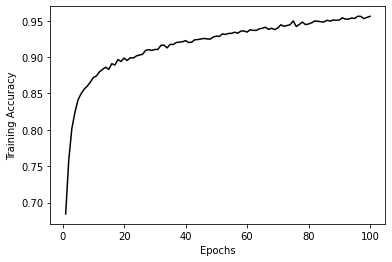

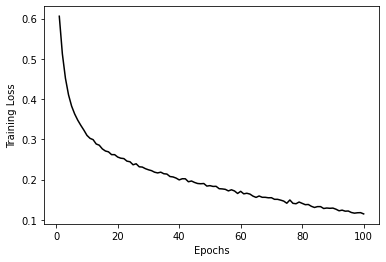

In [ ]:
accuracy = history_model2.history['accuracy']
loss = history_model2.history['loss']

graph_it(accuracy, "Training Accuracy")
graph_it(loss, "Training Loss")

### (Graded) Evaluate your model. 

This can be done by calling the evaluate funciton of your model with the relevent test data and labels. 

In [ ]:
test_loss2 = 0
test_acc2 = 0

########### WRITE YOUR CODE BELOW ######
test_loss2,test_acc2 = model23.evaluate(X_test_flat,y_test_cat)

########### END OF CODE ###############

print('\nTest accuracy:', test_acc2)
print("Test Loss:", test_loss2)

73/73 [==============================] - 0s 4ms/step - loss: 0.1805 - accuracy: 0.9309

Test accuracy: 0.930901288986206
Test Loss: 0.18053899705410004


### (Graded) Insert your results in this cell

For each of the 3 architectures you report, include number of layers, neurons in each layer, optimizer used, learning rate, batch size, number of epochs and accuracy achieved.

Also write your obeservations on how the multi-layer design compares against single layer design for this problem

########### WRITE YOUR RESULTS BELOW ######
> **Model1**

* *Hidden layers*:2
* *Neurons in Layer1*:100
* *Neurons in Layer2*:50
* *Optimizer*:Adam
* *batch size*:10
* *learning rate*:0.001
* *epochs*:50
* *Accuracy*:91%

---
> **Model2**

* *Hidden layers*:2
* *Neurons in Layer1*:200
* *Neurons in Layer2*:100
* *Optimizer*:Adam
* *batch size*:20
* *learning rate*:0.001
* *epochs*:80
* *Accuracy*:91.4%

---
> **Model3**

* *Hidden layers*:3
* *Neurons in Layer1*:500
* *Neurons in Layer2*:250
* *Neurons in Layer3*:100
* *Optimizer*:SGD
* *batch size*:10
* *learning rate*:0.001
* *epochs*:100
* *Accuracy*:93%

---

> **Observation**

Adding more layers enables the network to learn more complex intermediate features. Therefore, The multi-layer neural network was able to give the same accuracy as single hidden layer network with almost 3 times less parameters to learn.

############## END OF RESULTS #############